In [1]:
! pip install bnunicodenormalizer

In [2]:
! pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
from bnunicodenormalizer import Normalizer

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
url='/content/drive/MyDrive/Sentiment Analysis-Workshop_Deep Learning Models/dataset.csv'
df=pd.read_csv(url)
df.head()

,text,label
0,অসাধারণ নিশো বস্ আর অমি ভাইকেও।,positive
1,আমার দেখা বেস্ট নাটক,positive
2,"নাটক টা অনেক সুন্দর হয়েছে,,,,আফরান নিশো ভাইয়...",positive
3,সত্যি অসাধারণ একটি রিলেশন,positive
4,মজা পাইছি ভাষা গুলো কেমন লাগলো,positive


In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
df.head()

,text,label
0,অসাধারণ নিশো বস্ আর অমি ভাইকেও।,positive
1,আমার দেখা বেস্ট নাটক,positive
2,"নাটক টা অনেক সুন্দর হয়েছে,,,,আফরান নিশো ভাইয়...",positive
3,সত্যি অসাধারণ একটি রিলেশন,positive
4,মজা পাইছি ভাষা গুলো কেমন লাগলো,positive


In [9]:
!pip install bnunicodenormalizer
import re
import string
from nltk.corpus import stopwords
from bnunicodenormalizer import Normalizer # Import the Normalizer class from bnunicodenormalizer

def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Normalize text using bnunicodenormalizer
    #normalizer = Normalizer()
    #text = normalizer.bn_normalize(text) # Use the correct method name 'bn_normalize'

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(f"[{string.punctuation}]", "", text)

    # Remove numbers
    text = re.sub(r"\d+", "", text)

    # Remove extra whitespace
    text = text.strip()

    # Remove special characters and non-Bengali characters
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)

    # Correct common spelling variations (if any specific patterns are known)
    text = re.sub(r'ব্যাপক', 'বেশি', text)  # Example: correct 'ব্যাপক' to 'বেশি'

    # Tokenize the text (split into words)
    tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('bengali'))
    tokens = [word for word in tokens if word not in stop_words]

    # Optionally, apply lemmatization (if a suitable library is available)

    # Rejoin tokens into a single string
    text = " ".join(tokens)

    return text
df["text"] = df["text"].apply(preprocess_text)

In [10]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label']) # positive -> 1, negative -> 0

In [11]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

The fit_on_texts method is used to build the internal vocabulary index based on the texts in df['text']. This method:

Builds Vocabulary: Maps each unique word in the dataset to a unique integer. This is done by creating a word-to-index dictionary where words are assigned integer indices.
Counts Words: Counts the occurrences of each word in the dataset, which can be useful for understanding word frequencies.

In [12]:
# Save the DataFrame to a CSV file in Google Colab
df.to_csv('preprocessed_data.csv', index=False)

print("CSV file created successfully.")

CSV file created successfully.


In [13]:
from google.colab import files

# Download the CSV file
files.download('preprocessed_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
X = pad_sequences(sequences)
y = to_categorical(df['label'], num_classes=2)

In [15]:
X

array([[    0,     0,     0, ...,   744,   133,  5599],
       [    0,     0,     0, ...,     0,    65,     1],
       [    0,     0,     0, ...,   333,   838,   430],
       ...,
       [    0,     0,     0, ...,   393, 17044,  2182],
       [    0,     0,     0, ...,     0, 17045,   865],
       [    0,     0,     0, ...,     0, 17046, 17047]], dtype=int32)

In [16]:
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [17]:
from sklearn.model_selection import train_test_split

# Use X and y to create the training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

The pad_sequences function is used to ensure that all sequences in the dataset have the same length. This is important for feeding data into machine learning models, especially neural networks that expect inputs of uniform size.

maxlen: Specifies the desired length of the sequences. If a sequence is shorter than maxlen, it will be padded with zeros at the beginning (by default). If it is longer, it will be truncated from the beginning to fit maxlen.
X: The result is an array where all sequences have been padded or truncated to the length specified by maxlen.

vocab_size: The size of the vocabulary is calculated based on the number of unique words in the tokenizer’s word index. Adding 1 accounts for the reserved index 0 which is used for padding.

In [18]:
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense

# Define a function to build the RNN model with hyperparameters
def build_model(hp):
    model = Sequential()
    vocab_size = len(tokenizer.word_index) + 1
    maxlen = hp.Int('maxlen', min_value=50, max_value=300, step=50)

    # Embedding layer
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=hp.Choice('embedding_dim', values=[64, 128, 256]),
        input_length=maxlen
    ))

    # RNN layer
    model.add(SimpleRNN(
        units=hp.Int('rnn_units', min_value=64, max_value=256, step=64),
        return_sequences=False
    ))

    # Dropout layer
    model.add(Dropout(hp.Float('dropout_rate_1', min_value=0.3, max_value=0.7, step=0.1)))

    # Dense layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))

    # Dropout layer
    model.add(Dropout(hp.Float('dropout_rate_2', min_value=0.3, max_value=0.7, step=0.1)))

    # Output layer for binary classification
    model.add(Dense(2, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Initialize the RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Number of models to train for each combination
    directory='hyperparameter_tuning',
    project_name='rnn_tuning'
)

# Fit the tuner
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Summary of the best model
best_model.summary()


Trial 5 Complete [00h 02m 57s]
val_accuracy: 0.9195597171783447

Best val_accuracy So Far: 0.9218882322311401
Total elapsed time: 00h 15m 31s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 155, 128)            │       2,182,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,196,642 (8.38 MB)

 Trainable params: 2,196,642 (8.38 MB)

 Non-trainable params: 0 (0.00 B)

1. Model Building Function (build_model)
hp: The hp parameter is a HyperParameters object that allows you to define a range of values for various hyperparameters. Keras Tuner will try different combinations within these ranges to find the optimal set.
Embedding Layer:
The embedding layer converts integer-encoded words into dense vectors of fixed size.
vocab_size: The size of the vocabulary, determined by the tokenizer.
output_dim: The dimensionality of the embedding vectors, chosen from [64, 128, 256].
input_length: The maximum sequence length, which is a tunable parameter (maxlen) between 50 and 300, with steps of 50.
SimpleRNN Layer:
The RNN layer processes sequences of vectors (from the embedding layer).
units: The number of RNN units is a tunable parameter between 64 and 256, with steps of 64.
return_sequences=False: Only the last output in the sequence is returned, which is common for many-to-one sequence tasks like classification.
Dropout Layers:
Dropout layers help prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
Two dropout layers are used, with tunable dropout rates between 0.3 and 0.7, with steps of 0.1.
Dense Layer:
The dense layer is fully connected, with tunable units between 32 and 128, with steps of 32.
It uses the ReLU activation function, which is a common choice for hidden layers.
Output Layer:
The output layer has 2 units with a sigmoid activation function, designed for binary classification.
2. Compiling the Model
Optimizer: The model uses the Adam optimizer, which is adaptive and widely used.
Loss Function: The loss function is categorical_crossentropy, which is suitable for multi-class classification problems. However, since this is a binary classification problem, you might want to use binary_crossentropy instead.
3. Hyperparameter Tuning (RandomSearch)
Objective: The tuner aims to maximize val_accuracy, meaning it will seek the hyperparameters that give the best validation accuracy.
max_trials=5: The tuner will try 5 different combinations of hyperparameters.
executions_per_trial=2: Each combination of hyperparameters will be tried twice to ensure consistency in results.
4. Fitting the Tuner
The tuner searches for the best hyperparameter combination by fitting the model on X_train and y_train, and validating on X_val and y_val for 10 epochs.
5. Retrieving the Best Model
After the search is complete, the best model is retrieved using tuner.get_best_models(num_models=1)[0].
The summary of the best model can be printed using best_model.summary().


In [19]:
# Evaluate the model on the test set
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss * 100:.2f}%")



74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9248 - loss: 0.2456
Test Accuracy: 92.68%
Test Loss: 23.97%


In [20]:
# Predict the labels for the test set
y_pred = best_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


np.argmax(y_test, axis=1): Converts one-hot encoded true labels into class labels.
y_test: A 2D array where each row is a one-hot encoded vector representing the true class.
axis=1: Finds the index of the class with a value of 1 (the correct class) for each sample.
y_true: Contains the true class labels for each sample. It is a 1D array where each entry is the index of the class corresponding to the true label.

np.argmax(y_pred, axis=1): Converts the probabilities predicted by the model into class labels.
y_pred: A 2D array where each row corresponds to a sample, and each column corresponds to a class probability.
axis=1: Specifies that the argmax function should operate along the columns (i.e., across the class probabilities) to find the index (class label) with the highest probability for each sample.
y_pred_classes: Contains the predicted class labels for each sample. It is a 1D array where each entry is the index of the class with the highest probability.

In [21]:
# Generate a classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=['Negative', 'Positive']))

Classification Report:

              precision    recall  f1-score   support

    Negative       0.88      0.85      0.86       649
    Positive       0.94      0.96      0.95      1713

    accuracy                           0.93      2362
   macro avg       0.91      0.90      0.91      2362
weighted avg       0.93      0.93      0.93      2362



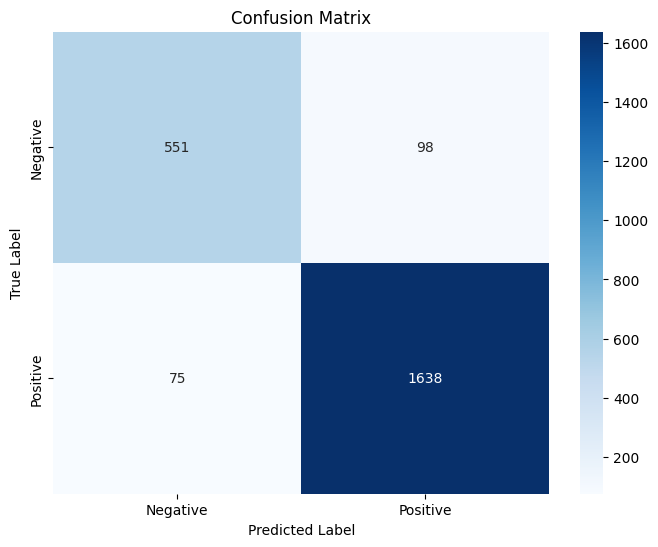

In [22]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [23]:
import pickle
from google.colab import files

# Save the tokenizer to a pickle file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
# Download the tokenizer pickle file
files.download('tokenizer.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# Save the model
best_model.save('hyperparametertunedonRNN.h5')

# Download the model file
from google.colab import files # imports the files object from google.colab
files.download('hyperparametertunedonRNN.h5') # calls the download function on the files object and uses the correct filename

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>